In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
from ipyleaflet import Map, AntPath, MeasureControl
import ipywidgets
from panel.interact import interact



In [2]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

In [3]:
# Read the census data into a Pandas DataFrame
file_path = Path("Scrubbed_data.csv")
alien_data = pd.read_csv(file_path)
alien_data['date'] = pd.to_datetime(alien_data['date'])


In [4]:
military_data = Path("military-bases.csv")
military_df = pd.read_csv(military_data)
military_df

COMPONENT                         Site Name  \
0    Army Active           Pohakuloa Training Area   
1    Army Active    Military Ocean Tml Sunny Point   
2    Army Active  Waianae Kai Military Reservation   
3    Army Active                 Picatinny Arsenal   
4    Navy Active             Arlington Service Ctr   
..           ...                               ...   
771  Navy Active                           Wahiawa   
772  Navy Active                            Dandan   
773  Navy Active                     SPAWARS South   
774    AF Active                   Rome Laboratory   
775  Army Active           Aberdeen Proving Ground   

                           Joint Base      State Terr        COUNTRY  \
0                                 NaN          Hawaii  United States   
1                                 NaN  North Carolina  United States   
2                                 NaN          Hawaii  United States   
3                                 NaN      New Jersey  United States   
4                                 NaN        Virginia  United States   
..                                ...             ...            ...   
771  Joint Base Pearl Harbor - Hickam          Hawaii  United States   
772             Joint Region Marianas            Guam           Guam   
773                               NaN      California  United States   
774                               NaN        New York  United States   
775                               NaN        Maryland  United States   

    Oper Stat  PERIMETER        AREA     Shape_Leng    Shape_Area   latitude  \
0      Active  89.064642  205.674769  152591.132000  6.042259e+08  19.714417   
1      Active  40.630225   18.030943   80617.741160  6.814751e+07  34.018212   
2      Active   1.015063    0.021070    1765.975570  6.330455e+04  21.446920   
3      Active  21.652624   10.274818   47441.757990  4.670101e+07  40.954310   
4      Active   0.803040    0.030300    1713.357672  1.296422e+05  38.867735   
..        ...        ...         ...            ...           ...        ...   
771    Active   7.113096    1.073077   12384.851770  3.227227e+06  21.520439   
772    Active   2.034633    0.248449    3307.200322  6.835910e+05  13.310684   
773    Active   1.425920    0.077609    2795.917591  2.844437e+05  32.667777   
774    Active   3.493360    0.130984    7971.688355  6.391309e+05  43.221496   
775    Active  56.009355  112.762587  120246.880300  4.896619e+08  39.389733   

      longitude  
0   -155.626601  
1    -77.973241  
2   -158.191081  
3    -74.544626  
4    -77.079335  
..          ...  
771 -158.005639  
772  144.736799  
773 -117.240517  
774  -75.409702  
775  -76.218481  

[776 rows x 12 columns]

In [5]:
lat_data = alien_data[['country name', 'city', 'latitude', 'longitude']]
lat_data

country name                         city   latitude  \
0      United States of America (the)                   santa cruz  36.974167   
1      United States of America (the)                        bouse  33.932500   
2                            Colombia            ibague (colombia)   4.440663   
3                                  UK      birmingham (uk/england)  52.466667   
4                             Cananda              ottawa (canada)  45.416667   
...                               ...                          ...        ...   
80326  United States of America (the)                       toledo  44.621667   
80327  United States of America (the)                         lyle  45.696111   
80328                         Ireland  kerry (republic of ireland)  52.154461   
80329                         Finland           helsinki (finland)  60.173324   
80330  United States of America (the)                       remote -46.163992   

        longitude  
0     -122.029722  
1     -114.005000  
2      -75.244141  
3       -1.916667  
4      -75.700000  
...           ...  
80326 -123.937222  
80327 -121.285000  
80328   -9.566863  
80329   24.941025  
80330  169.875050  

[80331 rows x 4 columns]

In [6]:
alien_df = alien_data.groupby('city').size().reset_index(name='Number of Sightings')
alien_df = alien_df.rename(columns={"city": "city_1"})
alien_df = alien_df.loc[alien_df['Number of Sightings']>=50,]
alien_df
            

city_1  Number of Sightings
177               albany                   79
203          albuquerque                  213
229           alexandria                   64
394              anaheim                   50
406            anchorage                   83
...                  ...                  ...
19168        westminster                   57
19315            wichita                   76
19424         wilmington                  101
19500  winnipeg (canada)                   71
19729             yakima                   87

[200 rows x 2 columns]

In [7]:
combined_data = pd.concat([alien_data, alien_df], axis="columns", join="inner")
combined_data = combined_data.drop(columns=['city_1'])
combined_data

datetime       date      time month       day  \
177       1/9/2011 5:30 2011-01-09   5:30:00   Jan    Sunday   
203      1/21/2006 0:00 2006-01-21   0:00:00   Jan  Saturday   
229    10/22/2013 18:30 2013-10-22  18:30:00   Oct   Tuesday   
394      9/1/1991 22:00 1991-09-01  22:00:00   Sep    Sunday   
406      4/5/2010 19:00 2010-04-05  19:00:00   Apr    Monday   
...                 ...        ...       ...   ...       ...   
19168    7/6/2013 19:30 2013-07-06  19:30:00   Jul  Saturday   
19315    4/10/1998 5:45 1998-04-10   5:45:00   Apr    Friday   
19424   8/21/2006 11:35 2006-08-21  11:35:00   Aug    Monday   
19500   9/22/2012 19:10 2012-09-22  19:10:00   Sep  Saturday   
19729    8/3/1997 21:15 1997-08-03  21:15:00   Aug    Sunday   

                                city  \
177                       terrebonne   
203                         fairborn   
229                  prescott valley   
394                      grants pass   
406                  cancun (mexico)   
...                              ...   
19168                         tucson   
19315                       el cajon   
19424                       mckinney   
19500                           mesa   
19729  palm springs (cathedral city)   

      location (land, in space, at sea, in flight) state country  \
177                                           land    OR      US   
203                                           land    OH      US   
229                                           land    AZ      US   
394                                           land    OR      US   
406                                           land   NaN      MX   
...                                            ...   ...     ...   
19168                                         land    AZ      US   
19315                                         land    CA      US   
19424                                         land    TX      US   
19500                                         land    AZ      US   
19729                                         land    CA      US   

                         country name     shape  duration (seconds)  \
177    United States of America (the)    circle            109800.0   
203    United States of America (the)   unknown             86400.0   
229    United States of America (the)     other             73800.0   
394    United States of America (the)     light             28800.0   
406                            Mexico  triangle             25200.0   
...                               ...       ...                 ...   
19168  United States of America (the)      oval               600.0   
19315  United States of America (the)     cigar               600.0   
19424  United States of America (the)    circle               600.0   
19500  United States of America (the)    circle               600.0   
19729  United States of America (the)     light               600.0   

      duration (hours/min)                                           comments  \
177            3 1/2 hours           2 UFOs sighted above our back pasture...   
203                all day  3 foot humaniod on back porch&#44 10 foot or s...   
229            2 1/2 hours  3 then up to 6 white flashing lights move erra...   
394                  8 hrs                       Light appeared over mountain   
406                7 hours  The object was glowing green and red. At times...   
...                    ...                                                ...   
19168           10 minutes                   6 red/orange orbs seen in Tucson   
19315           10 minutes  Observed object&#44 nothing around it.  Pulsin...   
19424               10 min  look  to the sky seen an object that  seem  to...   
19500         5-10 minutes      Four white round lights in a square formation   
19729           10 minutes  A &quot;UFO&quot; was erratically flying in th...   

      date posted   latitude   longitude  Number of Sightings  
177     1/31/2011  44.353056 -121.176667                  

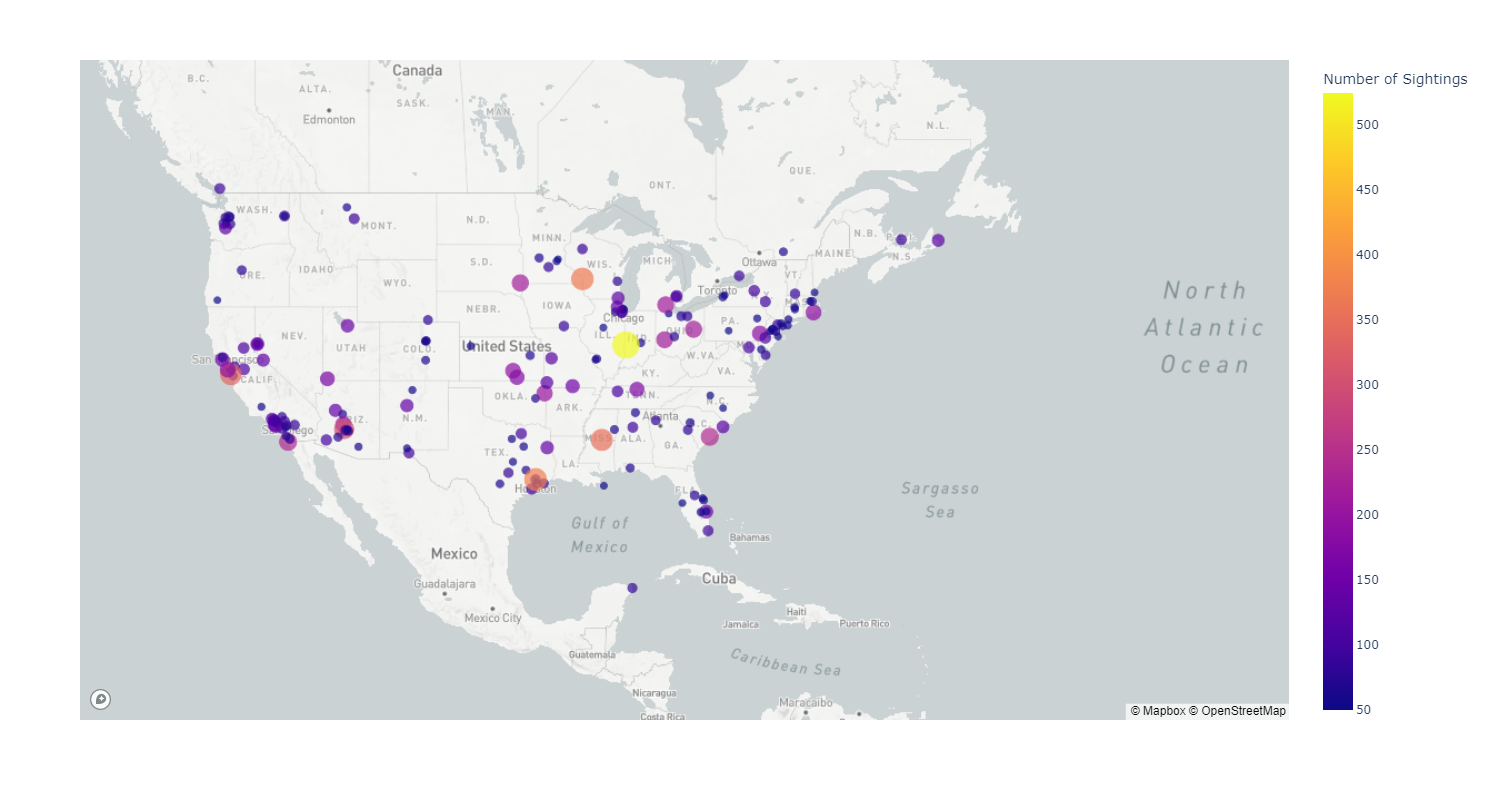

In [20]:
map_plot = px.scatter_mapbox(
    combined_data,
    size='Number of Sightings',
    lat="latitude",
    lon="longitude",
    color='Number of Sightings',
    hover_data=['country', 'day', 'month', 'time', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments' ],
    hover_name="city",
    zoom=3,
    height=800,
    width=1500
)
map_plot.show()

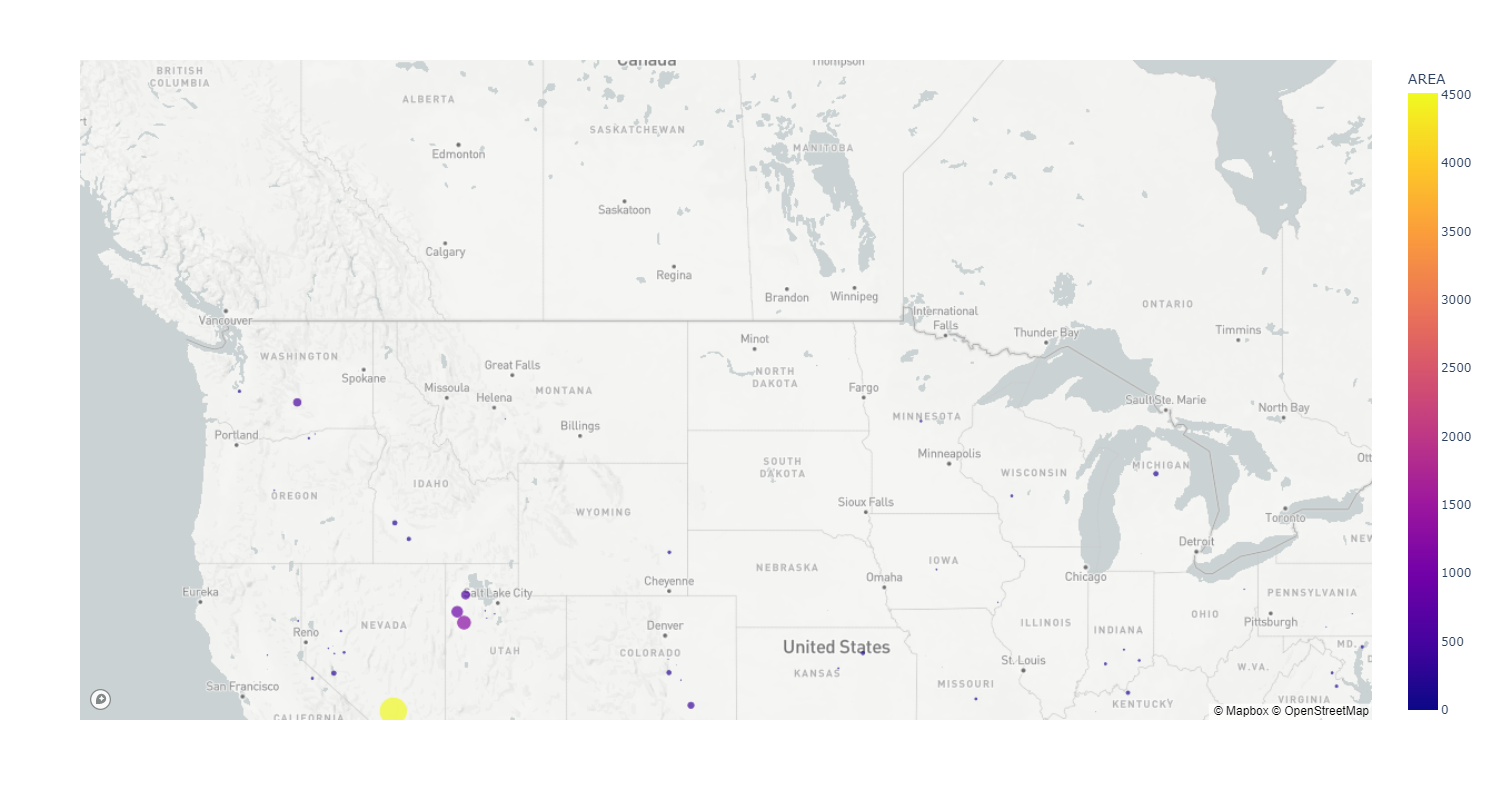

In [21]:
map_plot = px.scatter_mapbox(
    military_df,
    size='AREA',
    lat="latitude",
    lon="longitude",
    color='AREA',
    hover_data=['State Terr', 'COMPONENT', 'Joint Base','COUNTRY', 'Oper Stat', 'PERIMETER', 'AREA', 'Shape_Leng', 'Shape_Area'],
    hover_name="Site Name",
    zoom=3,
    height=800,
    width=1500
)
map_plot.show()

In [8]:
military_df = military_df[['Site Name', 'State Terr', 'latitude', 'longitude']]
military_df = military_df.rename(columns={"Site Name": "Site_Name"})
military_df


Site_Name      State Terr   latitude   longitude
0             Pohakuloa Training Area          Hawaii  19.714417 -155.626601
1      Military Ocean Tml Sunny Point  North Carolina  34.018212  -77.973241
2    Waianae Kai Military Reservation          Hawaii  21.446920 -158.191081
3                   Picatinny Arsenal      New Jersey  40.954310  -74.544626
4               Arlington Service Ctr        Virginia  38.867735  -77.079335
..                                ...             ...        ...         ...
771                           Wahiawa          Hawaii  21.520439 -158.005639
772                            Dandan            Guam  13.310684  144.736799
773                     SPAWARS South      California  32.667777 -117.240517
774                   Rome Laboratory        New York  43.221496  -75.409702
775           Aberdeen Proving Ground        Maryland  39.389733  -76.218481

[776 rows x 4 columns]

In [9]:
us_df = combined_data.loc[combined_data['country name']=="United States of America (the)",]
us_df = us_df.drop(columns='duration (seconds)')
us_df = us_df[['country name', 'city', 'state', 'latitude', 'longitude']]
us_df = us_df.rename(columns={"country name": "country_name"})
us_df

country_name                           city state  \
177    United States of America (the)                     terrebonne    OR   
203    United States of America (the)                       fairborn    OH   
229    United States of America (the)                prescott valley    AZ   
394    United States of America (the)                    grants pass    OR   
480    United States of America (the)          stratford (not exact)    CT   
...                               ...                            ...   ...   
19168  United States of America (the)                         tucson    AZ   
19315  United States of America (the)                       el cajon    CA   
19424  United States of America (the)                       mckinney    TX   
19500  United States of America (the)                           mesa    AZ   
19729  United States of America (the)  palm springs (cathedral city)    CA   

        latitude   longitude  
177    44.353056 -121.176667  
203    39.820833  -84.019444  
229    34.610000 -112.315000  
394    42.439167 -123.327222  
480    41.184444  -73.133611  
...          ...         ...  
19168  32.221667 -110.925833  
19315  32.794722 -116.961667  
19424  33.197500  -96.615000  
19500  33.422222 -111.821944  
19729  33.830278 -116.544444  

[175 rows x 5 columns]

In [39]:
# widgets
start_dropdown = ipywidgets.Dropdown(options=list(military_df.Site_Name),
                                     value=list(military_df.Site_Name)[0],
                                     description='Military Base',
                                     disabled=False)

end_dropdown = ipywidgets.Dropdown(options=list(us_df.city),
                                   value=list(us_df.city)[1],
                                   description='Alien Sighting',
                                   disabled=False)

# function
# calculate distance from a to b
# display map with ant path from a to b
def get_coordinates(a, b):
    start_lat = military_df[military_df.Site_Name == a].latitude.values[0]
    start_lon = military_df[military_df.Site_Name == a].longitude.values[0]
    end_lat = us_df[us_df.city == b].latitude.values[0]
    end_lon = us_df[us_df.city == b].longitude.values[0]
    df_data = pd.DataFrame({'lat': [start_lat, end_lat], 'lon': [start_lon,end_lon]})
    start = (start_lat, start_lon),
    end = (end_lat, end_lon)

    
    m = px.line_mapbox(df_data, lat="lat", lon="lon", title = 'Distance between Military Base: ' + a + ' and Sighting Location: ' +  b + ' is: ' + str(round(distance.distance(start, end).miles, 2)) + ' miles')
    m.show()
    return 
    
# interaction between function and widget
ipywidgets.interact(get_coordinates, a=start_dropdown, b=end_dropdown);

interactive(children=(Dropdown(description='Military Base', options=('Pohakuloa Training Area', 'Military Ocea…